[Click here to try to open this notebook in Google Colab](https://githubtocolab.com/engmaths/SEMT30003_2024/blob/main/data/Brochier_et_al/brochier_et_al_excerpt.ipynb)

In [1]:
from pylab import * # note: shadows some built-in keywords
matplotlib.rc('image',interpolation='nearest',aspect='auto',origin='lower',cmap='bone_r')
matplotlib.rc('legend',loc='center left',frameon=False,markerscale=10)

## Extracellular Recordings

This notebook will load and plot some example neural recordings
from [Brochier, Thomas, et al. (2018)](https://www.nature.com/articles/sdata201855).
There are no exercises, but you may want to explore more on your own later.
These data are extracted from the file [i140703-001_lfp-spikes.mat](https://gin.g-node.org/INT/multielectrode_grasp/src/master/datasets_matlab/i140703-001_lfp-spikes.mat)
from [this public dataset.](gin.g-node.org/INT/multielectrode_grasp)

> Brochier, Thomas, et al. "Massively parallel recordings in macaque 
> motor cortex during an instructed delayed reach-to-grasp task." 
> Scientific data 5.1 (2018): 1-23.

***Do not worry if this notebook refers to concepts that are not yet clear, we will cover these topics in time. Any examinable material will be provided as lecture notes, for a definitive reference.***

## Get the data

The file is [on Github here](https://github.com/engmaths/SEMT30003_2024/blob/main/data/Brochier_et_al/brochier_et_al_excerpt.npz).
Loading data directly from Github to Colab is not officially supported by Microsoft/Google, but you can 

1. Try to run the cell below with the hard-coded download link; if that fails
2. Download the notebook file from github and upload to colab through the web interface.

In [3]:
from urllib.request import urlretrieve

repo = 'https://github.com/engmaths/SEMT30003_2024/raw/main/'
fdir = "/data/Brochier_et_al/"
fn   = "brochier_et_al_excerpt.npz"
path = repo + fdir + fn
urlretrieve(path,fn)

data = np.load('brochier_et_al_excerpt.npz')
print("contents:")
print('  '+'\n  '.join(data.keys())) # What is inside?
globals().update(data) # put data into global (notebook) scope

contents:
  unit_id
  channel_id
  waveform_examples
  trial_spikes
  trial_lfp
  ms_start
  ms_cue
  ms_go
  ms_stop
  fs_waveform
  fs
  allow_pickle


## About the data

These data are taken from 

> [Brochier, Thomas, et al. "Massively parallel recordings in macaque 
> motor cortex during an instructed delayed reach-to-grasp task." 
> Scientific data 5.1 (2018): 1-23.](https://www.nature.com/articles/sdata201855)


The full data for this paper can be found at
[https://gin.g-node.org/INT/multielectrode_grasp](https://gin.g-node.org/INT/multielectrode_grasp)

This example uses data from the file [`i140703-001_lfp-spikes.mat`](gin.g-node.org/INT/multielectrode_grasp/src/master/datasets_matlab/i140703-001_lfp-spikes.mat
).
This is only a small subset of the available data and metadata. Please refer to the  `i140703-001_lfp-spikes` for the full details.

#### Variables


`unit_id:` 
> List of neuron ID numbers in the original Brochier et al. data.

`channel_id:` 
> List of LFP channel ID numbers in the original Brochier et al. data.

`waveform_examples:` neurons × sample × time(@30KHz) float16 array
> For each unit, 500 randomly selected spikes waveforms saved at the higher 30 KHz sampling rate. Units are microvolts.

`trial_spikes:` trials × neurons × time(@1KHz) uint8 array
> For each trial and unit, an array of timesamples where 1 denotes "spike" and 0 denotes "no spike".

`trial_lfp:` trials × channels × time(@1KHz) float16 array
> For each trial and electrode, the low-pass electrical voltage recorded at 1 KHz. Units are millivolts.

`ms_start:` int
> bin (ms) that each trial starts

`ms_cue:` int
> bin (ms) when cue was presented in each trial

`ms_go:` int
> bin (ms) when go signal was presented in each trial

`ms_stop:` int
> bin (ms) when subject completed each trial

`fs_waveform:` int
> Sample rate of waveform data

`fs:` int
> Sample rate of spike rasters, LFP data



## Spikes

These are the average voltage traces of spikes from isolated single neurons.

These signals were recorded from ***extracellular*** silicon electrodes implanted in cortex. 
This approach does not record the voltage inside each neuron, but rather currents that result in the surrounding tissue. Notice that these voltage traces will be upside-down (negative is depolarized), and distorted by the filtering involved in analog-to-digital conversion.

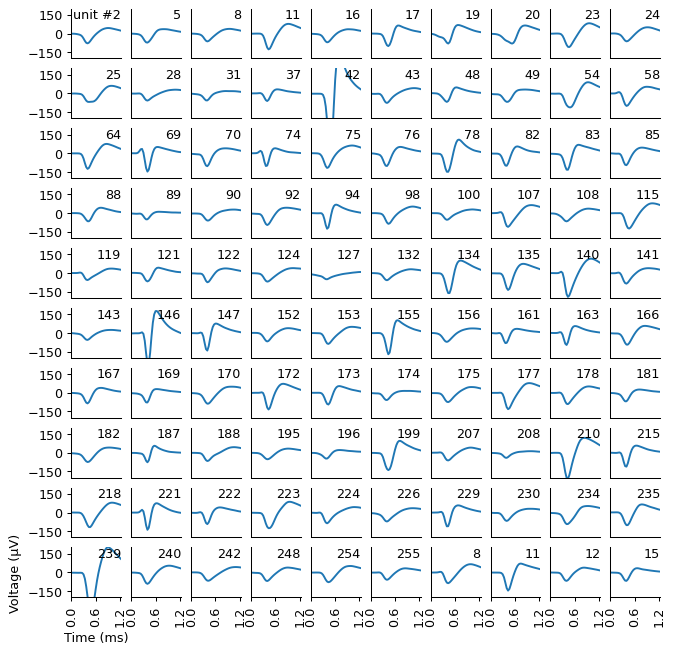

In [4]:
nneuron, nwaveform, nsample = shape(waveform_examples)

wt_ms = arange(nsample)/fs_waveform*1000

figure(0,(8,8),92)
subplots_adjust(0.1,0.1,0.9,0.9,0.2,0.2)
for r in range(10):
    for c in range(10):
        i = r*10+c
        subplot(10,10,i+1)
        plot(wt_ms,mean(waveform_examples[i],axis=0))
        xlim(wt_ms[0],wt_ms[-1])
        ylim(-200,200)
        yticks([] if c>0 else [-150,0,150])
        xticks([] if r<9 else [0,0.6,1.2],rotation=90)
        if r==9 and c==0: xlabel('Time (ms)')
        if c==0 and r==9: ylabel('Voltage (μV)')
        gca().spines[['right', 'top']].set_visible(False)
        text(xlim()[1],ylim()[1],("unit #" if r==c==0 else '')+str(unit_id[i]),ha='right',va='top')

# Population spike raster

A population spike raster plots simultaneously-recorded spiking events from several neurons. 
The presence of a spike for the given neuron, 1 millisecond time bin, is denoted by a black pixel in the figure below. 

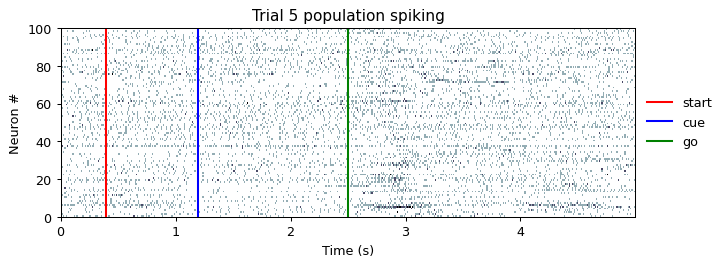

In [5]:
ntrial, nneuron, trialms = shape(trial_spikes)
trials   = trialms/1000 # trial length in seconds
tt_s     = arange(trialms)/1000 # time in seconds for each bin
binwidth = 10 # 10 ms @1KHz
nbin     = trialms//binwidth # Number of bins
itrial   = 5  # Which trial index to plot?
dt_ms    = 1000/fs  # bin duration milliseconds

# Bin spiking data into 10 ms bins
project = kron(eye(nbin),ones((1,binwidth))).T
binsum = trial_spikes@project

# Plot spikes from all neurons, one trial
figure(0,(8,3),92)
subplots_adjust(0.1,0.1,0.9,0.9,0.2,0.2)
imshow(1000*binsum[itrial],extent=(tt_s[0],tt_s[-1],0,nneuron))
ylabel("Neuron #")
xlabel("Time (s)")
title("Trial %d population spiking"%itrial)

# Label events 
axvline(ms_start[itrial]/1000, lw=1.6, color='r', label="start")
axvline(ms_cue[itrial]/1000,   lw=1.6, color='b', label="cue")
axvline(ms_go[itrial]/1000,    lw=1.6, color='g', label="go")
legend(bbox_to_anchor=(1,0.5))
tight_layout()

# Stimulus-aligned spiking

In this figure, we've chosen *one* neuron, and plotted its activity on *all* repeated trials. 
We chose to align trials based on the "go" cue, but other possibilities include e.g. the time the subject completes the trial. 

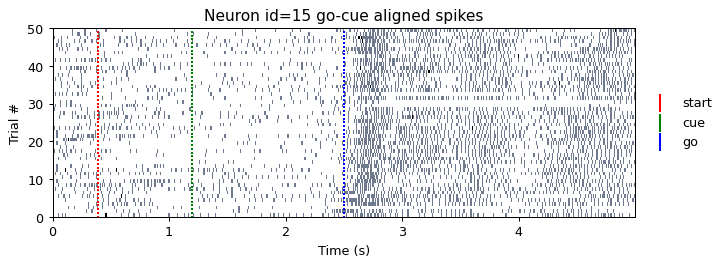

In [6]:
ineuron = 13 # Which unit to examine?

# Plot spikes from one neuron, all trials
figure(0,(8,3),92)
imshow(binsum[:,ineuron],extent=(tt_s[0],tt_s[-1],0,ntrial))
ylabel("Trial #")
xlabel("Time (s)")
title("Neuron id=%d go-cue aligned spikes"%unit_id[i])

# Label events from each trial (slight timing variations)
ii = arange(ntrial)
opts = dict(lw=1.6,s=2,marker='|')
scatter(ms_start/1000,ii, color='r', label="start", **opts)
scatter(ms_cue  /1000,ii, color='g', label="cue"  , **opts)
scatter(ms_go   /1000,ii, color='b', label="go"   , **opts)
legend(bbox_to_anchor=(1,0.5),markerscale=10)
tight_layout()

# Peristimulus Time Histogram (PSTH)

If we align recorded spiking to a particular event over repeated trials, 
we can average the spiking activity over trials to estimate how the neuron's
spiking rate is modulated by the event. 

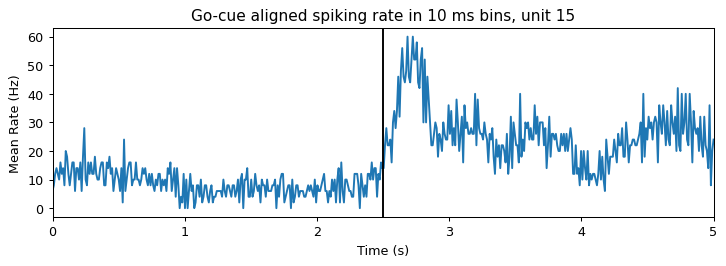

In [7]:
ineuron = 13 # Which unit to examine?

# Plot average go-cue-aligned spiking rate over trials
figure(0,(8,3),92)
plot(linspace(0,trialms/1000,nbin),mean(binsum[:,ineuron],0)*(fs/binwidth))
axvline(ms_go[0]/1000, color='k', label="go")
xlim(0,trials)
ylabel('Mean Rate (Hz)')
xlabel('Time (s)')
title("Go-cue aligned spiking rate in %d ms bins, unit %d"%(binwidth*dt_ms,unit_id[i]))
tight_layout()

### Local Field Potentials (LFP)

Electrodes implanted in the brain can detect the average electrical activity in nearby neurons. 
The precise contributions to these voltage fluctuations vary depending on the setup.
Currents flowing through synapses are usually a large contributor. 

This plot shows the electrical activity recorded from a single electrode over multiple trial repetitions.

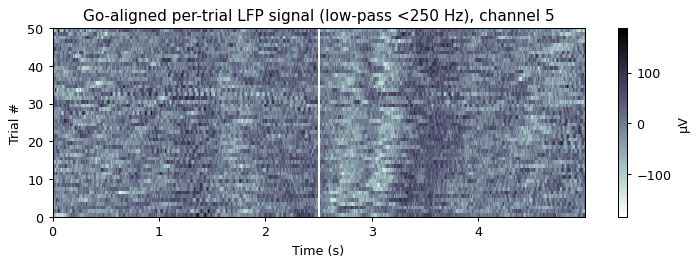

In [8]:
ichannel = 4 # Which channel to examine?

figure(0,(8,3),92)
subplots_adjust(0.1,0.1,0.9,0.9,0.2,0.2)
imshow(trial_lfp[:,ichannel],extent=(tt_s[0],tt_s[-1],0,ntrial))
axvline(ms_go[0]/1000, color='w', label="go")
colorbar(label='μV')
title("Go-aligned per-trial LFP signal (low-pass <250 Hz), channel %d"%channel_id[ichannel])
ylabel("Trial #")
xlabel("Time (s)")
tight_layout()

### Event-triggered average of LFP voltage

Just as we calculated the average spiking rate from a single neuron in the *Peristimulus Time histogram (PSTH)*, we can also calculate event-triggered averages of continuous signals, for example LFP voltage.

Notice the large change after the "go" cue, when the subject starts to move. Movement generates a large electrical potential that can actually be detected *outside* the skull. This signal is called a [motor evoked potential](https://en.wikipedia.org/wiki/Event-related_potential), and can be recorded by electroencephalography (EEG), which places electrodes touching the skin on the head. 

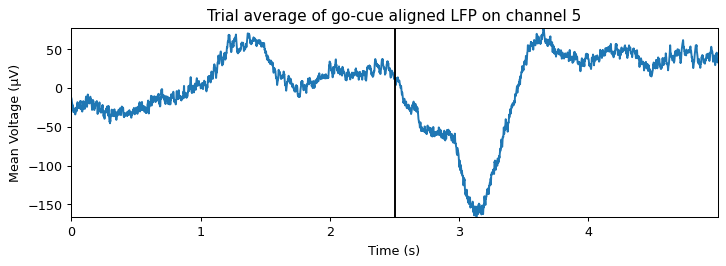

In [9]:
figure(0,(8,3),92)
subplots_adjust(0.1,0.1,0.9,0.9,0.2,0.2)
plot(tt_s,mean(trial_lfp[:,0],axis=0))
axvline(ms_go[0]/1000, color='k', label="go")
autoscale(enable=True, axis='both', tight=True)
xlabel('Time (s)')
ylabel('Mean Voltage (μV)')
title("Trial average of go-cue aligned LFP on channel %d"%channel_id[ichannel])
tight_layout()